Variational Auto-Encoders
=========================
This code implements a Variation Auto-Encoder (VAE). If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [ ]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118 #uncomment to enforce cuda 11.8

if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm


%matplotlib inline
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from matplotlib import gridspec

import os
if os.path.exists('./training') == False:
  os.mkdir('./training')

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Hyper-Parameters
----------------

In [ ]:
batch_size = 3000     # batch size
latent_dim = 100      # latent-space dimension
middle_dim = 128      # size of the middle layer
learning_rate = 1e-3  # learning rate
max_epochs = 50       # maximum number of epochs
use_gpu = True        # using the GPU

Loading the Dataset
-------------------
As in the GAN example, we will be using the MNIST dataset. MNIST images show digits from 0-9 in 28x28 grayscale images.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# image dimensions
input_dim = 28**2

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13384121.16it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1102085.19it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9552811.18it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5223616.33it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



VAE Definition
--------------
We will now use a specific scheme to initialize our weights, called Xavier initialization. You can neglect this if you are using other layers than fully connected.

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

The following model represents the distribution encoder distribution q(z|x), together with the reparametrization trick.

In [ ]:
class Q(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(Q, self).__init__()
    self.lin_middle = nn.Linear(input_dim, middle_dim, bias=True)
    self.lin_mu = nn.Linear(middle_dim, latent_dim, bias=True)
    self.lin_var = nn.Linear(middle_dim, latent_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_middle)
    init_weights(self.lin_mu)
    init_weights(self.lin_var)

  def forward(self, input):
    # forward
    middle = F.relu(self.lin_middle(input))
    z_mu = self.lin_mu(middle)
    z_var = self.lin_var(middle)
    return z_mu, z_var

We now model the reparametrization trick.

In [ ]:
class Reparametrization(nn.Module):
  def __init__(self):
    super(Reparametrization, self).__init__()

  def forward(self, z_mu, z_var):
    eps = torch.randn(z_var.size(0), z_var.size(1), device=device) # sample on a unit Gaussian
    return z_mu + torch.exp(z_var/2) * eps

The following model represents the decoder P(x|z).

In [ ]:
class P(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(P, self).__init__()
    self.lin_latent = nn.Linear(latent_dim, middle_dim, bias=True)
    self.lin_middle = nn.Linear(middle_dim, input_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_latent)
    init_weights(self.lin_middle)

  def forward(self, latent):
    middle = F.relu(self.lin_latent(latent))
    return F.sigmoid(self.lin_middle(middle))

Training
--------

We first initialize an instance of the model and load it onto GPU if relevant.

In [ ]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the GPU (faster).
Number of parameters for encoder: 114064 and decoder: 126280


We can now do the training properly speaking.

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training...


Epoch 0: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


	[Losses] Total 2.62 - Recon. 2.48 - KL 0.133


Epoch 1: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


	[Losses] Total 1.57 - Recon. 1.44 - KL 0.126


Epoch 2: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 1.42 - Recon. 1.32 - KL 0.109


Epoch 3: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


	[Losses] Total 1.32 - Recon. 1.2 - KL 0.12


Epoch 4: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


	[Losses] Total 1.25 - Recon. 1.13 - KL 0.128


Epoch 5: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


	[Losses] Total 1.2 - Recon. 1.07 - KL 0.133


Epoch 6: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


	[Losses] Total 1.17 - Recon. 1.03 - KL 0.136


Epoch 7: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


	[Losses] Total 1.14 - Recon. 1.0 - KL 0.139


Epoch 8: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


	[Losses] Total 1.12 - Recon. 0.976 - KL 0.142


Epoch 9: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


	[Losses] Total 1.1 - Recon. 0.956 - KL 0.145


Epoch 10: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


	[Losses] Total 1.08 - Recon. 0.938 - KL 0.146


Epoch 11: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 1.07 - Recon. 0.919 - KL 0.148


Epoch 12: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


	[Losses] Total 1.05 - Recon. 0.903 - KL 0.15


Epoch 13: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


	[Losses] Total 1.04 - Recon. 0.888 - KL 0.152


Epoch 14: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 1.03 - Recon. 0.873 - KL 0.154


Epoch 15: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


	[Losses] Total 1.02 - Recon. 0.861 - KL 0.154


Epoch 16: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 1.0 - Recon. 0.849 - KL 0.155


Epoch 17: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


	[Losses] Total 0.995 - Recon. 0.839 - KL 0.156


Epoch 18: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


	[Losses] Total 0.99 - Recon. 0.834 - KL 0.156


Epoch 19: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.98 - Recon. 0.823 - KL 0.157


Epoch 20: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


	[Losses] Total 0.971 - Recon. 0.814 - KL 0.157


Epoch 21: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 0.966 - Recon. 0.808 - KL 0.158


Epoch 22: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


	[Losses] Total 0.959 - Recon. 0.801 - KL 0.158


Epoch 23: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 0.953 - Recon. 0.794 - KL 0.158


Epoch 24: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


	[Losses] Total 0.945 - Recon. 0.787 - KL 0.158


Epoch 25: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


	[Losses] Total 0.94 - Recon. 0.78 - KL 0.159


Epoch 26: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 0.934 - Recon. 0.775 - KL 0.16


Epoch 27: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


	[Losses] Total 0.93 - Recon. 0.77 - KL 0.16


Epoch 28: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 0.923 - Recon. 0.763 - KL 0.16


Epoch 29: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


	[Losses] Total 0.919 - Recon. 0.757 - KL 0.161


Epoch 30: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 0.912 - Recon. 0.75 - KL 0.161


Epoch 31: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


	[Losses] Total 0.909 - Recon. 0.748 - KL 0.161


Epoch 32: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.903 - Recon. 0.741 - KL 0.162


Epoch 33: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


	[Losses] Total 0.899 - Recon. 0.736 - KL 0.162


Epoch 34: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


	[Losses] Total 0.893 - Recon. 0.731 - KL 0.162


Epoch 35: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 0.89 - Recon. 0.727 - KL 0.162


Epoch 36: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


	[Losses] Total 0.886 - Recon. 0.723 - KL 0.163


Epoch 37: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


	[Losses] Total 0.88 - Recon. 0.717 - KL 0.163


Epoch 38: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


	[Losses] Total 0.878 - Recon. 0.715 - KL 0.163


Epoch 39: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


	[Losses] Total 0.873 - Recon. 0.71 - KL 0.163


Epoch 40: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


	[Losses] Total 0.87 - Recon. 0.707 - KL 0.163


Epoch 41: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


	[Losses] Total 0.865 - Recon. 0.702 - KL 0.163


Epoch 42: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.863 - Recon. 0.7 - KL 0.163


Epoch 43: 100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


	[Losses] Total 0.857 - Recon. 0.695 - KL 0.162


Epoch 44: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


	[Losses] Total 0.856 - Recon. 0.693 - KL 0.163


Epoch 45: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


	[Losses] Total 0.852 - Recon. 0.69 - KL 0.162


Epoch 46: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


	[Losses] Total 0.846 - Recon. 0.683 - KL 0.163


Epoch 47: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


	[Losses] Total 0.847 - Recon. 0.684 - KL 0.162


Epoch 48: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


	[Losses] Total 0.841 - Recon. 0.678 - KL 0.162


Epoch 49: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


	[Losses] Total 0.841 - Recon. 0.679 - KL 0.162
Done.


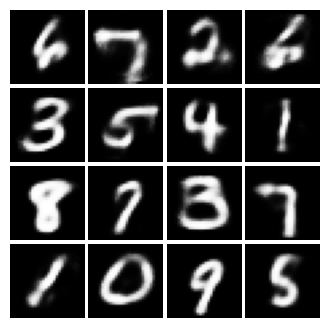

In [ ]:
# set models to train mode
p.train()
q.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(size_average=False, reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):

  avg_total_loss = 0
  avg_recon_loss = 0
  avg_kl_loss = 0

  for _, (batch, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
    batch = batch.to(device) # load the data onto GPU is relevant
    batch = batch.view(batch_size, -1)

    # forward
    z_mu, z_var = q(batch)
    z = reparam(z_mu, z_var)
    batch_recon = p(z)

    # reconstruction loss E[log P(X|z)]
    recon_loss = bce(batch_recon, batch) / len(batch)
    # distribution loss D_KL(Q(z|X) || P(z))
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    # Total loss
    total_loss = recon_loss + kl_loss

    # backward
    total_loss.backward()

    # update
    optim.step()

    # housekeeping
    optim.zero_grad()
    avg_total_loss += total_loss / len(batch)
    avg_recon_loss += recon_loss / len(batch)
    avg_kl_loss += kl_loss / len(batch)

  # end of epoch
  total_losses.append(avg_total_loss.item())
  recon_losses.append(avg_recon_loss.item())
  kl_losses.append(avg_kl_loss.item())
  print(f"\t[Losses] Total {total_losses[-1]:.3} - Recon. {recon_losses[-1]:.3} - KL {kl_losses[-1]:.3}")

  # plot
  if epoch % 2 == 0:
        samples = p(z).data.cpu().numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('training/'):
            os.makedirs('out/')
        # plt.show()
        # plt.pause(0.1)
        plt.savefig('training/{}_{}.png'.format(epoch, str(current_image).zfill(3)), bbox_inches='tight')
        current_image += 1
        # plt.close(fig)

print("Done.")

We can now plot the training curves.

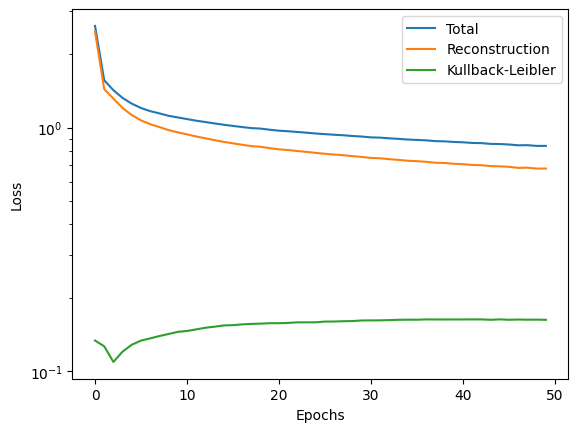

In [ ]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generation
----------

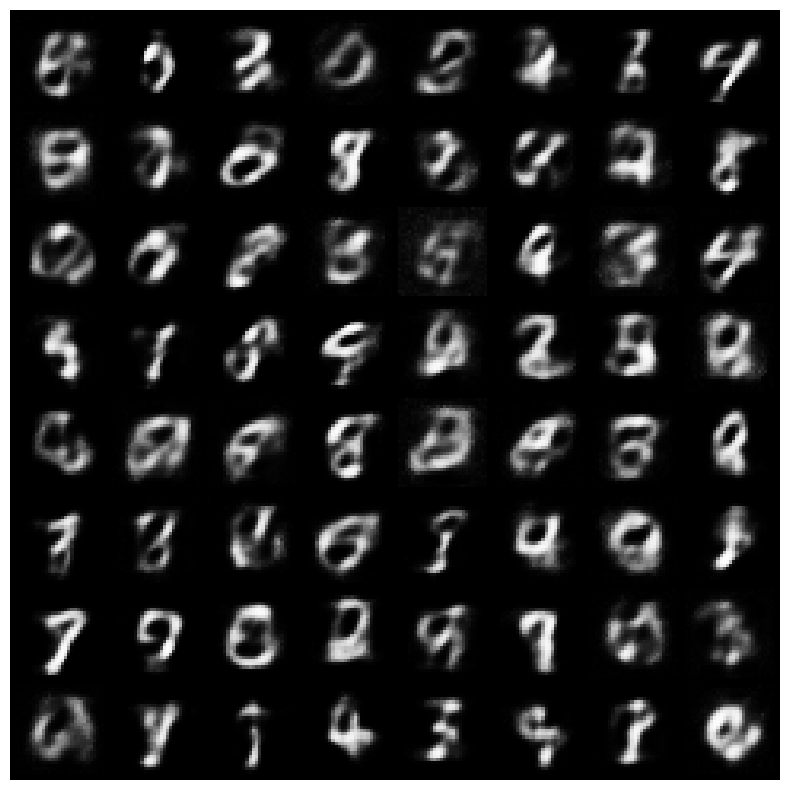

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**2, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**2, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = correct_shape(fake_image_batch)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

Visualization in Latent Space
-----------------------------

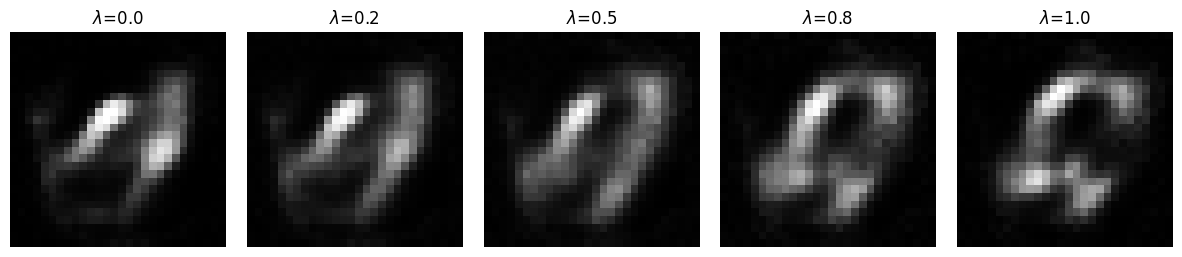

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()

def correct_shape(imgs):
  return imgs.view(-1, 28, 28).unsqueeze(1)

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn((1, latent_dim), device=device)
latent_2 = torch.randn((1, latent_dim), device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), p, latent_1, latent_2)

    inter_image = correct_shape(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()

In [ ]:
latent_dim = 1000

In [ ]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the GPU (faster).
Number of parameters for encoder: 229264 and decoder: 358480


Training...


Epoch 0: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


	[Losses] Total 2.52 - Recon. 2.41 - KL 0.105


Epoch 1: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


	[Losses] Total 1.53 - Recon. 1.44 - KL 0.0914


Epoch 2: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


	[Losses] Total 1.43 - Recon. 1.34 - KL 0.0884


Epoch 3: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 1.35 - Recon. 1.25 - KL 0.0976


Epoch 4: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


	[Losses] Total 1.28 - Recon. 1.17 - KL 0.111


Epoch 5: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 1.22 - Recon. 1.1 - KL 0.12


Epoch 6: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


	[Losses] Total 1.19 - Recon. 1.07 - KL 0.12


Epoch 7: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


	[Losses] Total 1.16 - Recon. 1.04 - KL 0.122


Epoch 8: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 1.13 - Recon. 1.01 - KL 0.124


Epoch 9: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


	[Losses] Total 1.11 - Recon. 0.983 - KL 0.127


Epoch 10: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


	[Losses] Total 1.09 - Recon. 0.96 - KL 0.128


Epoch 11: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


	[Losses] Total 1.07 - Recon. 0.943 - KL 0.129


Epoch 12: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


	[Losses] Total 1.05 - Recon. 0.924 - KL 0.13


Epoch 13: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


	[Losses] Total 1.04 - Recon. 0.912 - KL 0.131


Epoch 14: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


	[Losses] Total 1.03 - Recon. 0.901 - KL 0.132


Epoch 15: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


	[Losses] Total 1.02 - Recon. 0.89 - KL 0.132


Epoch 16: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


	[Losses] Total 1.01 - Recon. 0.881 - KL 0.133


Epoch 17: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 1.01 - Recon. 0.872 - KL 0.135


Epoch 18: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


	[Losses] Total 1.0 - Recon. 0.865 - KL 0.136


Epoch 19: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


	[Losses] Total 0.995 - Recon. 0.859 - KL 0.137


Epoch 20: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


	[Losses] Total 0.989 - Recon. 0.851 - KL 0.138


Epoch 21: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


	[Losses] Total 0.986 - Recon. 0.846 - KL 0.14


Epoch 22: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


	[Losses] Total 0.979 - Recon. 0.839 - KL 0.141


Epoch 23: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


	[Losses] Total 0.977 - Recon. 0.835 - KL 0.142


Epoch 24: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


	[Losses] Total 0.973 - Recon. 0.83 - KL 0.143


Epoch 25: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


	[Losses] Total 0.97 - Recon. 0.826 - KL 0.144


Epoch 26: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


	[Losses] Total 0.967 - Recon. 0.822 - KL 0.145


Epoch 27: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


	[Losses] Total 0.964 - Recon. 0.818 - KL 0.146


Epoch 28: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


	[Losses] Total 0.962 - Recon. 0.815 - KL 0.147


Epoch 29: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


	[Losses] Total 0.959 - Recon. 0.811 - KL 0.148


Epoch 30: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


	[Losses] Total 0.956 - Recon. 0.807 - KL 0.148


Epoch 31: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


	[Losses] Total 0.954 - Recon. 0.805 - KL 0.149


Epoch 32: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.951 - Recon. 0.801 - KL 0.15


Epoch 33: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


	[Losses] Total 0.951 - Recon. 0.8 - KL 0.15


Epoch 34: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.947 - Recon. 0.796 - KL 0.152


Epoch 35: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


	[Losses] Total 0.946 - Recon. 0.794 - KL 0.152


Epoch 36: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 0.943 - Recon. 0.79 - KL 0.153


Epoch 37: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


	[Losses] Total 0.941 - Recon. 0.788 - KL 0.153


Epoch 38: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


	[Losses] Total 0.938 - Recon. 0.784 - KL 0.154


Epoch 39: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 0.939 - Recon. 0.785 - KL 0.154


Epoch 40: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


	[Losses] Total 0.937 - Recon. 0.781 - KL 0.155


Epoch 41: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


	[Losses] Total 0.935 - Recon. 0.779 - KL 0.156


Epoch 42: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


	[Losses] Total 0.933 - Recon. 0.777 - KL 0.157


Epoch 43: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


	[Losses] Total 0.932 - Recon. 0.775 - KL 0.157


Epoch 44: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


	[Losses] Total 0.929 - Recon. 0.77 - KL 0.158


Epoch 45: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


	[Losses] Total 0.93 - Recon. 0.771 - KL 0.158


Epoch 46: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 0.927 - Recon. 0.767 - KL 0.159


Epoch 47: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


	[Losses] Total 0.925 - Recon. 0.766 - KL 0.159


Epoch 48: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


	[Losses] Total 0.923 - Recon. 0.763 - KL 0.16


Epoch 49: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 0.921 - Recon. 0.76 - KL 0.161
Done.


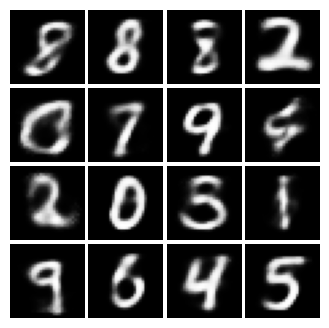

In [ ]:
# set models to train mode
p.train()
q.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(size_average=False, reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):

  avg_total_loss = 0
  avg_recon_loss = 0
  avg_kl_loss = 0

  for _, (batch, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
    batch = batch.to(device) # load the data onto GPU is relevant
    batch = batch.view(batch_size, -1)

    # forward
    z_mu, z_var = q(batch)
    z = reparam(z_mu, z_var)
    batch_recon = p(z)

    # reconstruction loss E[log P(X|z)]
    recon_loss = bce(batch_recon, batch) / len(batch)
    # distribution loss D_KL(Q(z|X) || P(z))
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    # Total loss
    total_loss = recon_loss + kl_loss

    # backward
    total_loss.backward()

    # update
    optim.step()

    # housekeeping
    optim.zero_grad()
    avg_total_loss += total_loss / len(batch)
    avg_recon_loss += recon_loss / len(batch)
    avg_kl_loss += kl_loss / len(batch)

  # end of epoch
  total_losses.append(avg_total_loss.item())
  recon_losses.append(avg_recon_loss.item())
  kl_losses.append(avg_kl_loss.item())
  print(f"\t[Losses] Total {total_losses[-1]:.3} - Recon. {recon_losses[-1]:.3} - KL {kl_losses[-1]:.3}")

  # plot
  if epoch % 2 == 0:
        samples = p(z).data.cpu().numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('training/'):
            os.makedirs('out/')
        # plt.show()
        # plt.pause(0.1)
        plt.savefig('training/{}_{}.png'.format(epoch, str(current_image).zfill(3)), bbox_inches='tight')
        current_image += 1
        # plt.close(fig)

print("Done.")

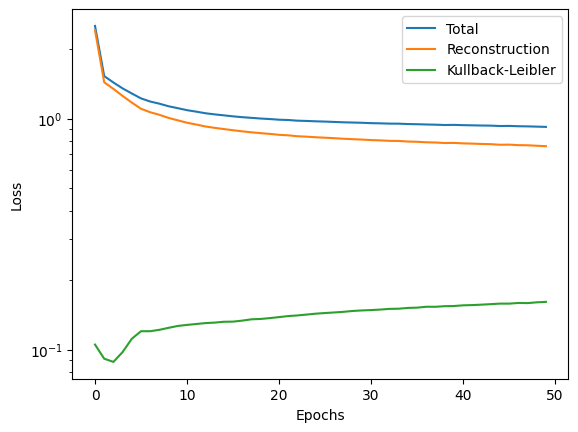

In [ ]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

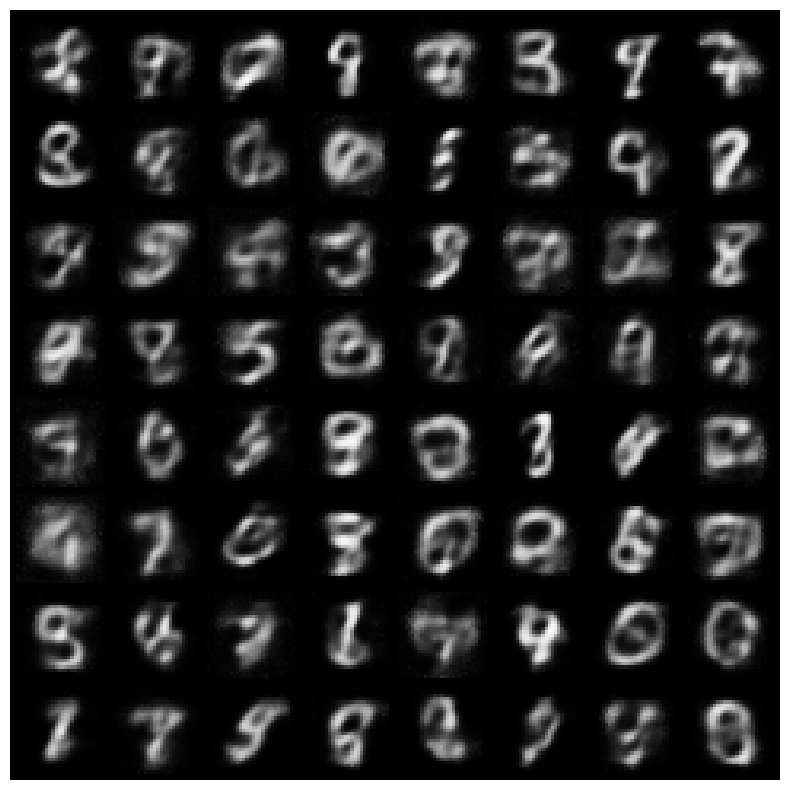

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**2, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**2, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = correct_shape(fake_image_batch)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

In [ ]:
latent_dim = 10

In [ ]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the GPU (faster).
Number of parameters for encoder: 102544 and decoder: 103060


Training...


Epoch 0: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


	[Losses] Total 2.81 - Recon. 2.66 - KL 0.145


Epoch 1: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 1.69 - Recon. 1.5 - KL 0.19


Epoch 2: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


	[Losses] Total 1.47 - Recon. 1.32 - KL 0.145


Epoch 3: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


	[Losses] Total 1.33 - Recon. 1.2 - KL 0.135


Epoch 4: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 1.24 - Recon. 1.11 - KL 0.132


Epoch 5: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


	[Losses] Total 1.17 - Recon. 1.04 - KL 0.13


Epoch 6: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 1.13 - Recon. 1.01 - KL 0.127


Epoch 7: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


	[Losses] Total 1.1 - Recon. 0.976 - KL 0.125


Epoch 8: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


	[Losses] Total 1.07 - Recon. 0.95 - KL 0.123


Epoch 9: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


	[Losses] Total 1.05 - Recon. 0.927 - KL 0.123


Epoch 10: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


	[Losses] Total 1.03 - Recon. 0.91 - KL 0.122


Epoch 11: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 1.02 - Recon. 0.898 - KL 0.121


Epoch 12: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


	[Losses] Total 1.0 - Recon. 0.884 - KL 0.12


Epoch 13: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 0.99 - Recon. 0.87 - KL 0.12


Epoch 14: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


	[Losses] Total 0.982 - Recon. 0.862 - KL 0.12


Epoch 15: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


	[Losses] Total 0.97 - Recon. 0.851 - KL 0.119


Epoch 16: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


	[Losses] Total 0.964 - Recon. 0.845 - KL 0.119


Epoch 17: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


	[Losses] Total 0.955 - Recon. 0.837 - KL 0.118


Epoch 18: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 0.949 - Recon. 0.832 - KL 0.117


Epoch 19: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


	[Losses] Total 0.943 - Recon. 0.826 - KL 0.117


Epoch 20: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 0.936 - Recon. 0.819 - KL 0.117


Epoch 21: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.931 - Recon. 0.815 - KL 0.116


Epoch 22: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


	[Losses] Total 0.928 - Recon. 0.812 - KL 0.116


Epoch 23: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 0.921 - Recon. 0.806 - KL 0.116


Epoch 24: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


	[Losses] Total 0.919 - Recon. 0.804 - KL 0.115


Epoch 25: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


	[Losses] Total 0.913 - Recon. 0.799 - KL 0.115


Epoch 26: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


	[Losses] Total 0.909 - Recon. 0.795 - KL 0.114


Epoch 27: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 0.909 - Recon. 0.795 - KL 0.114


Epoch 28: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


	[Losses] Total 0.902 - Recon. 0.789 - KL 0.114


Epoch 29: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


	[Losses] Total 0.899 - Recon. 0.785 - KL 0.113


Epoch 30: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.897 - Recon. 0.784 - KL 0.113


Epoch 31: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


	[Losses] Total 0.893 - Recon. 0.78 - KL 0.113


Epoch 32: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.891 - Recon. 0.778 - KL 0.113


Epoch 33: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


	[Losses] Total 0.887 - Recon. 0.775 - KL 0.113


Epoch 34: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 0.886 - Recon. 0.773 - KL 0.113


Epoch 35: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


	[Losses] Total 0.882 - Recon. 0.77 - KL 0.112


Epoch 36: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


	[Losses] Total 0.88 - Recon. 0.768 - KL 0.112


Epoch 37: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


	[Losses] Total 0.878 - Recon. 0.766 - KL 0.112


Epoch 38: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


	[Losses] Total 0.875 - Recon. 0.763 - KL 0.112


Epoch 39: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 0.873 - Recon. 0.762 - KL 0.112


Epoch 40: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


	[Losses] Total 0.871 - Recon. 0.759 - KL 0.112


Epoch 41: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 0.87 - Recon. 0.758 - KL 0.112


Epoch 42: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


	[Losses] Total 0.866 - Recon. 0.754 - KL 0.112


Epoch 43: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


	[Losses] Total 0.864 - Recon. 0.753 - KL 0.111


Epoch 44: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 0.863 - Recon. 0.752 - KL 0.112


Epoch 45: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


	[Losses] Total 0.861 - Recon. 0.75 - KL 0.112


Epoch 46: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 0.859 - Recon. 0.747 - KL 0.112


Epoch 47: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


	[Losses] Total 0.858 - Recon. 0.746 - KL 0.112


Epoch 48: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


	[Losses] Total 0.855 - Recon. 0.743 - KL 0.112


Epoch 49: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


	[Losses] Total 0.854 - Recon. 0.742 - KL 0.112
Done.


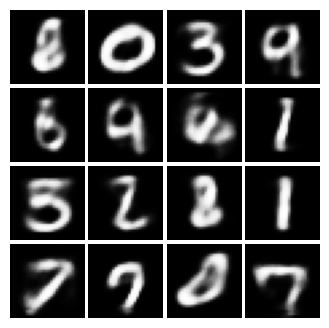

In [ ]:
# set models to train mode
p.train()
q.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(size_average=False, reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):

  avg_total_loss = 0
  avg_recon_loss = 0
  avg_kl_loss = 0

  for _, (batch, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
    batch = batch.to(device) # load the data onto GPU is relevant
    batch = batch.view(batch_size, -1)

    # forward
    z_mu, z_var = q(batch)
    z = reparam(z_mu, z_var)
    batch_recon = p(z)

    # reconstruction loss E[log P(X|z)]
    recon_loss = bce(batch_recon, batch) / len(batch)
    # distribution loss D_KL(Q(z|X) || P(z))
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    # Total loss
    total_loss = recon_loss + kl_loss

    # backward
    total_loss.backward()

    # update
    optim.step()

    # housekeeping
    optim.zero_grad()
    avg_total_loss += total_loss / len(batch)
    avg_recon_loss += recon_loss / len(batch)
    avg_kl_loss += kl_loss / len(batch)

  # end of epoch
  total_losses.append(avg_total_loss.item())
  recon_losses.append(avg_recon_loss.item())
  kl_losses.append(avg_kl_loss.item())
  print(f"\t[Losses] Total {total_losses[-1]:.3} - Recon. {recon_losses[-1]:.3} - KL {kl_losses[-1]:.3}")

  # plot
  if epoch % 2 == 0:
        samples = p(z).data.cpu().numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('training/'):
            os.makedirs('out/')
        # plt.show()
        # plt.pause(0.1)
        plt.savefig('training/{}_{}.png'.format(epoch, str(current_image).zfill(3)), bbox_inches='tight')
        current_image += 1
        # plt.close(fig)

print("Done.")

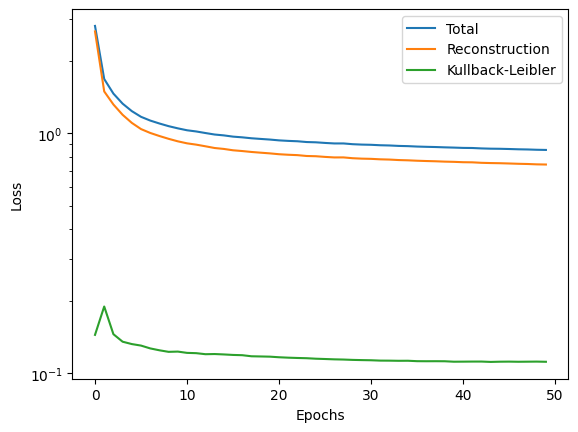

In [ ]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

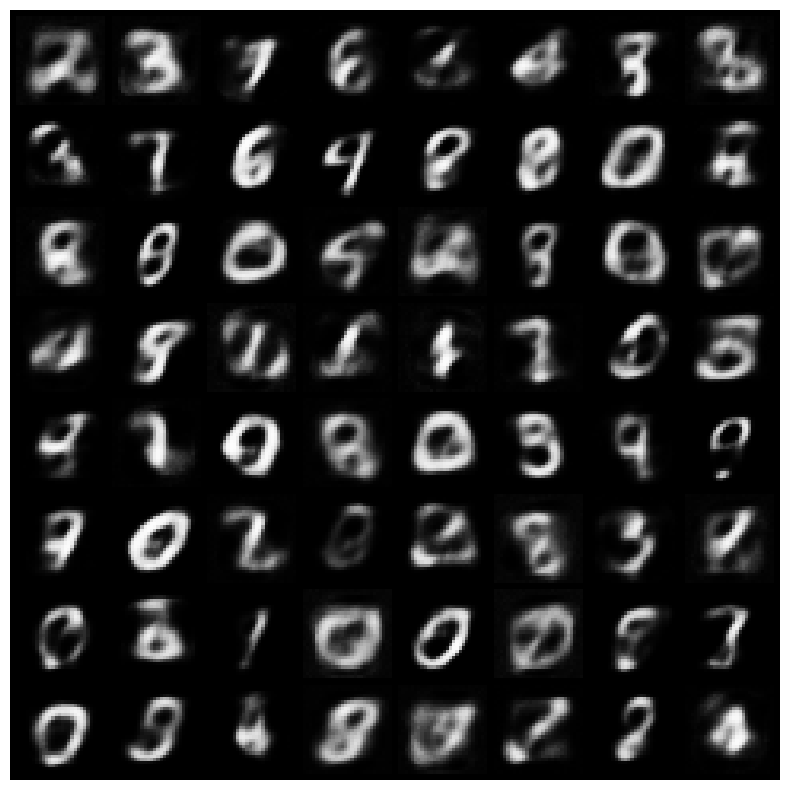

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**2, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**2, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = correct_shape(fake_image_batch)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

In [ ]:
latent_dim = 3

In [ ]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the GPU (faster).
Number of parameters for encoder: 101648 and decoder: 101254


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training...


Epoch 0: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


	[Losses] Total 2.81 - Recon. 2.62 - KL 0.186


Epoch 1: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


	[Losses] Total 1.79 - Recon. 1.56 - KL 0.225


Epoch 2: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


	[Losses] Total 1.56 - Recon. 1.39 - KL 0.164


Epoch 3: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


	[Losses] Total 1.43 - Recon. 1.3 - KL 0.132


Epoch 4: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


	[Losses] Total 1.35 - Recon. 1.25 - KL 0.108


Epoch 5: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 1.3 - Recon. 1.21 - KL 0.0922


Epoch 6: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


	[Losses] Total 1.27 - Recon. 1.19 - KL 0.0832


Epoch 7: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


	[Losses] Total 1.25 - Recon. 1.17 - KL 0.0758


Epoch 8: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


	[Losses] Total 1.23 - Recon. 1.16 - KL 0.0705


Epoch 9: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 1.21 - Recon. 1.15 - KL 0.067


Epoch 10: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


	[Losses] Total 1.2 - Recon. 1.14 - KL 0.0641


Epoch 11: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


	[Losses] Total 1.19 - Recon. 1.13 - KL 0.0615


Epoch 12: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


	[Losses] Total 1.18 - Recon. 1.12 - KL 0.0596


Epoch 13: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


	[Losses] Total 1.17 - Recon. 1.11 - KL 0.0583


Epoch 14: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


	[Losses] Total 1.16 - Recon. 1.11 - KL 0.0567


Epoch 15: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


	[Losses] Total 1.15 - Recon. 1.1 - KL 0.0558


Epoch 16: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


	[Losses] Total 1.15 - Recon. 1.09 - KL 0.0549


Epoch 17: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


	[Losses] Total 1.14 - Recon. 1.09 - KL 0.0541


Epoch 18: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


	[Losses] Total 1.14 - Recon. 1.08 - KL 0.0536


Epoch 19: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


	[Losses] Total 1.13 - Recon. 1.08 - KL 0.0529


Epoch 20: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 1.12 - Recon. 1.07 - KL 0.0524


Epoch 21: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


	[Losses] Total 1.12 - Recon. 1.07 - KL 0.052


Epoch 22: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


	[Losses] Total 1.11 - Recon. 1.06 - KL 0.0516


Epoch 23: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 1.11 - Recon. 1.06 - KL 0.0512


Epoch 24: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


	[Losses] Total 1.1 - Recon. 1.05 - KL 0.051


Epoch 25: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


	[Losses] Total 1.1 - Recon. 1.05 - KL 0.0508


Epoch 26: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


	[Losses] Total 1.09 - Recon. 1.04 - KL 0.0504


Epoch 27: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


	[Losses] Total 1.09 - Recon. 1.04 - KL 0.0502


Epoch 28: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


	[Losses] Total 1.08 - Recon. 1.03 - KL 0.05


Epoch 29: 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


	[Losses] Total 1.08 - Recon. 1.03 - KL 0.0498


Epoch 30: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


	[Losses] Total 1.07 - Recon. 1.03 - KL 0.0497


Epoch 31: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


	[Losses] Total 1.07 - Recon. 1.02 - KL 0.0495


Epoch 32: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 1.07 - Recon. 1.02 - KL 0.0493


Epoch 33: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


	[Losses] Total 1.06 - Recon. 1.01 - KL 0.0491


Epoch 34: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


	[Losses] Total 1.06 - Recon. 1.01 - KL 0.049


Epoch 35: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


	[Losses] Total 1.06 - Recon. 1.01 - KL 0.0489


Epoch 36: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


	[Losses] Total 1.05 - Recon. 1.0 - KL 0.0489


Epoch 37: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


	[Losses] Total 1.05 - Recon. 1.0 - KL 0.0486


Epoch 38: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


	[Losses] Total 1.05 - Recon. 1.0 - KL 0.0486


Epoch 39: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


	[Losses] Total 1.05 - Recon. 0.998 - KL 0.0485


Epoch 40: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


	[Losses] Total 1.04 - Recon. 0.995 - KL 0.0486


Epoch 41: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


	[Losses] Total 1.04 - Recon. 0.993 - KL 0.0485


Epoch 42: 100%|██████████| 20/20 [00:05<00:00,  3.33it/s]


	[Losses] Total 1.04 - Recon. 0.99 - KL 0.0485


Epoch 43: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


	[Losses] Total 1.04 - Recon. 0.989 - KL 0.0484


Epoch 44: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


	[Losses] Total 1.04 - Recon. 0.987 - KL 0.0485


Epoch 45: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


	[Losses] Total 1.03 - Recon. 0.985 - KL 0.0485


Epoch 46: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


	[Losses] Total 1.03 - Recon. 0.983 - KL 0.0485


Epoch 47: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


	[Losses] Total 1.03 - Recon. 0.981 - KL 0.0484


Epoch 48: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


	[Losses] Total 1.03 - Recon. 0.98 - KL 0.0485


Epoch 49: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]

	[Losses] Total 1.03 - Recon. 0.979 - KL 0.0486
Done.


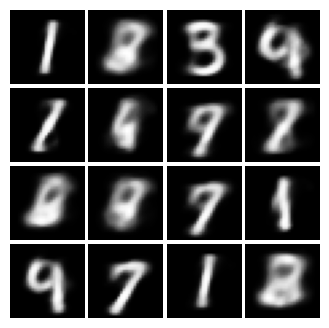

In [ ]:
# set models to train mode
p.train()
q.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(size_average=False, reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):

  avg_total_loss = 0
  avg_recon_loss = 0
  avg_kl_loss = 0

  for _, (batch, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
    batch = batch.to(device) # load the data onto GPU is relevant
    batch = batch.view(batch_size, -1)

    # forward
    z_mu, z_var = q(batch)
    z = reparam(z_mu, z_var)
    batch_recon = p(z)

    # reconstruction loss E[log P(X|z)]
    recon_loss = bce(batch_recon, batch) / len(batch)
    # distribution loss D_KL(Q(z|X) || P(z))
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    # Total loss
    total_loss = recon_loss + kl_loss

    # backward
    total_loss.backward()

    # update
    optim.step()

    # housekeeping
    optim.zero_grad()
    avg_total_loss += total_loss / len(batch)
    avg_recon_loss += recon_loss / len(batch)
    avg_kl_loss += kl_loss / len(batch)

  # end of epoch
  total_losses.append(avg_total_loss.item())
  recon_losses.append(avg_recon_loss.item())
  kl_losses.append(avg_kl_loss.item())
  print(f"\t[Losses] Total {total_losses[-1]:.3} - Recon. {recon_losses[-1]:.3} - KL {kl_losses[-1]:.3}")

  # plot
  if epoch % 2 == 0:
        samples = p(z).data.cpu().numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('training/'):
            os.makedirs('out/')
        # plt.show()
        # plt.pause(0.1)
        plt.savefig('training/{}_{}.png'.format(epoch, str(current_image).zfill(3)), bbox_inches='tight')
        current_image += 1
        # plt.close(fig)

print("Done.")

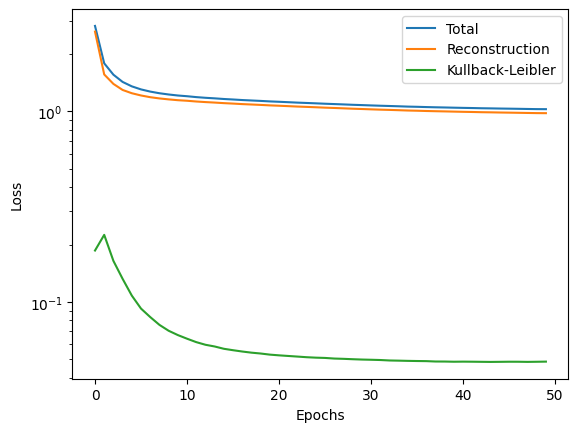

In [ ]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

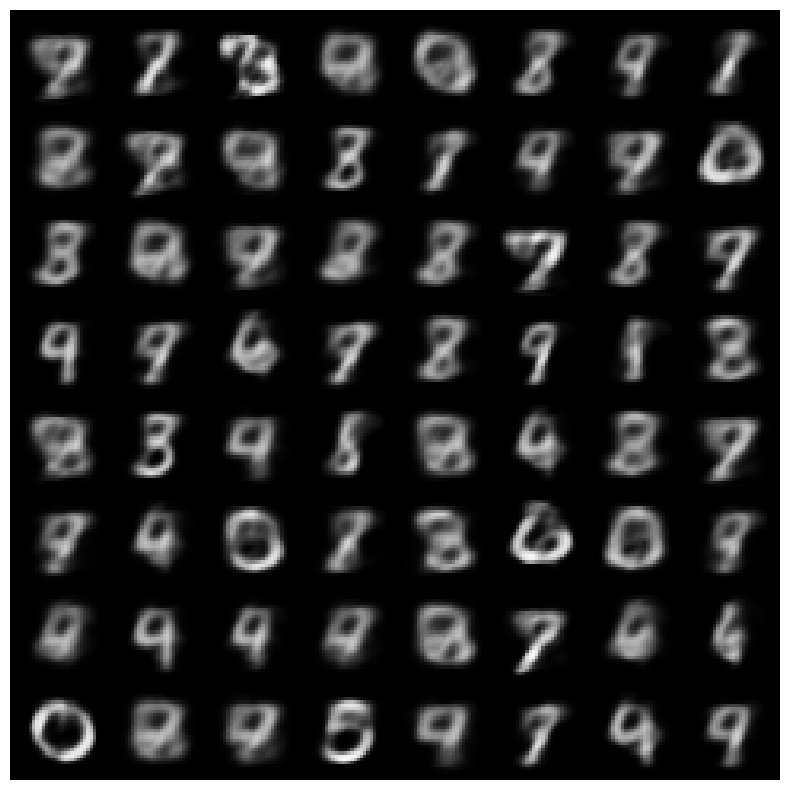

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**2, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**2, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = correct_shape(fake_image_batch)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()